## 1. Tiền xử lý dữ liệu

In [1]:
import numpy as np
import pandas as pd
from pyvi import ViTokenizer

text = content = open("data/truyen_kieu_data.txt", "r", encoding="utf-8").read()

### Loại bỏ dấu câu

In [2]:
def loai_bo_dau_cau(text):
    dau_cau = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for p in dau_cau:
        text = text.replace(p, '')
    return text

### Tạo bộ từ vựng

In [3]:
def tao_vocab(text):
    unique_words = list(set(text))
    vocab = pd.DataFrame({
        'word': unique_words,
        'index': range(len(unique_words))
    })
    return vocab

### Tiền xử lý dữ liệu

In [4]:
def tien_xu_ly(text):
    text = text.lower()
    text = loai_bo_dau_cau(text)
    text = ViTokenizer.tokenize(text)
    text = text.split()
    stopwords = [
    "là", "và", "của", "có", "cho", "với", "một", "được", "này", "như",
    "cũng", "nhưng", "rằng", "trong", "khi", "đã", "đang", "tôi", "chúng", "bạn",
    "vì", "thì", "sẽ", "thế", "nên", "điều", "đây", "đó", "nào", "thôi"
    ]
    text = [word for word in text if word.lower() not in stopwords]
    text
    vocabulary = tao_vocab(text)
    return text, vocabulary

## 2. Thiết kế mô hình skip-gram

In [5]:
# def one_hot(words, word_to_index):
#     one_hot_matrix = np.zeros((len(words), len(word_to_index)), dtype=int)
#     for i, word in enumerate(words):
#         index = word_to_index[word]
#         one_hot_matrix[i, index] = 1
#     return one_hot_matrix

In [6]:
def one_hot(context_words, word_to_index):
    y_true = np.zeros(len(word_to_index))
    for word in context_words:
        y_true[word_to_index[word]] = 1
    return y_true

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## 3. Huấn luyện mô hình

In [8]:
EPOCHS = 30
LEARNING_RATE = 0.01
WINDOW_SIZE = 2

### center_word, contex_word

In [9]:
def tao_cap_skipgram(words, window_size=WINDOW_SIZE):
    pairs = []
    for i in range(len(words)):
        for neighbor in range(1, window_size + 1):
            if i - neighbor >= 0:
                pairs.append((words[i], words[i - neighbor]))
            if i + neighbor < len(words):
                pairs.append((words[i], words[i + neighbor]))
    return pairs

### Foward pass

In [10]:
def forward(center_word, context_words, W_in, W_out, word_to_index):
    center_idx = word_to_index[center_word]
    h = W_in[center_idx]
    u = W_out.T @ h
    y_pred = softmax(u)
    y_true = one_hot(context_words, word_to_index)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9))
    return y_pred, loss, h, y_true

### Backward pass

In [11]:
def backward(h, y_pred, y_true, W_out):
    error = y_pred - y_true
    dW_out = np.outer(h, error)
    dW_in = W_out @ error
    return dW_in, dW_out

### Train model

In [12]:
def train_skipgram_model(data, word_to_index, W_in, W_out, epochs, learning_rate):
    for epoch in range(epochs):
        total_loss = 0
        for i in range(1, len(data) - 1):
            center_word = data[i]
            context_words = [data[i - 1], data[i + 1]]

            y_pred, loss, h, y_true = forward(center_word, context_words, W_in, W_out, word_to_index)
            total_loss += loss

            dW_in, dW_out = backward(h, y_pred, y_true, W_out)

            center_idx = word_to_index[center_word]
            W_in[center_idx] -= learning_rate * dW_in
            for context_word in context_words:
                context_idx = word_to_index[context_word]
                W_out[:, context_idx] -= learning_rate * dW_out[:, context_idx]

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
    return W_in, W_out

In [13]:
text, vocab = tien_xu_ly(text)
word_to_index = {row['word']: row['index'] for _, row in vocab.iterrows()}

In [14]:
v = len(vocab)
d = 100
embedding_matrix = np.random.uniform(-0.01, 0.01, (v, d))
output_matrix = np.random.uniform(-0.01, 0.01, (d, v))
skipgram_pairs = tao_cap_skipgram(text)

In [15]:
embedding_matrix, output_matrix = train_skipgram_model(text, word_to_index, embedding_matrix, output_matrix, EPOCHS, LEARNING_RATE)

Epoch 1/30, Loss: 304847.4712
Epoch 2/30, Loss: 304843.4048
Epoch 3/30, Loss: 304837.1869
Epoch 4/30, Loss: 304822.9175
Epoch 5/30, Loss: 304777.8496
Epoch 6/30, Loss: 304611.0145
Epoch 7/30, Loss: 303958.2199
Epoch 8/30, Loss: 301659.5154
Epoch 9/30, Loss: 297831.8489
Epoch 10/30, Loss: 294555.8883
Epoch 11/30, Loss: 291961.1741
Epoch 12/30, Loss: 290337.2663
Epoch 13/30, Loss: 289197.1163
Epoch 14/30, Loss: 288376.4483
Epoch 15/30, Loss: 287920.7898
Epoch 16/30, Loss: 287826.6880
Epoch 17/30, Loss: 287955.6473
Epoch 18/30, Loss: 288167.7893
Epoch 19/30, Loss: 288288.5939
Epoch 20/30, Loss: 288199.1734
Epoch 21/30, Loss: 287930.1774
Epoch 22/30, Loss: 287575.6103
Epoch 23/30, Loss: 287221.2781
Epoch 24/30, Loss: 286941.1592
Epoch 25/30, Loss: 286702.1927
Epoch 26/30, Loss: 286426.6337
Epoch 27/30, Loss: 286105.0038
Epoch 28/30, Loss: 285818.4118
Epoch 29/30, Loss: 285644.8294
Epoch 30/30, Loss: 285583.1255


## 4. Đánh giá Embedding Vector

### Cosine Similarity
    [1] https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/

In [16]:
from numpy.linalg import norm

def cosine_similarity(vec1, vec2):
    return vec1 @ vec2 / (norm(vec1) * norm(vec2))

In [17]:
# Bộ từ kiểm tra
word_pairs = [
    ("thẹn_thùng", "e_lệ"),
    ("vui", "khóc"), 
    ("máu_ghen", "khát_khao")  
]

print("Cosine similarity:")
for word1, word2 in word_pairs:
    if word1 in word_to_index and word2 in word_to_index:
        vec1 = embedding_matrix[word_to_index[word1]]
        vec2 = embedding_matrix[word_to_index[word2]]
        similarity = cosine_similarity(vec1, vec2)
        print(f"({word1}, {word2}): {similarity:.4f}")
    else:
        print(f"({word1}, {word2}): Một trong hai từ không có trong từ điển.")


Cosine similarity:
(thẹn_thùng, e_lệ): 0.2796
(vui, khóc): -0.0718
(máu_ghen, khát_khao): -0.2826


### Visualization

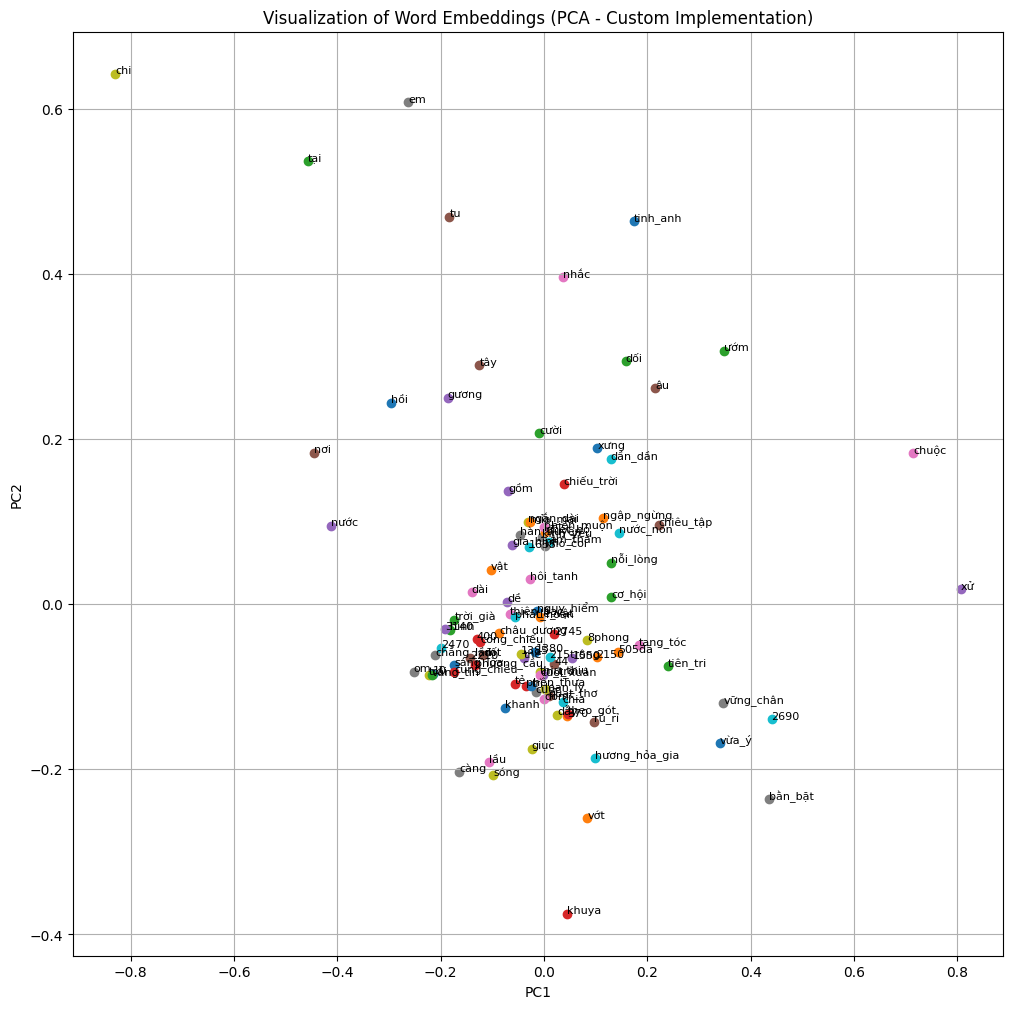

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random
def pca(data, n_components=2):
    mean = np.mean(data, axis=0)
    data_centered = data - mean
    cov_matrix = np.cov(data_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    principal_components = eigenvectors[:, :n_components]
    reduced_data = np.dot(data_centered, principal_components)
    return reduced_data
reduced_embeddings = pca(embedding_matrix, n_components=2)
num_words_to_plot = 100
selected_words = random.sample(list(word_to_index.items()), num_words_to_plot)
plt.figure(figsize=(12, 12))
for word, index in selected_words:
    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])
    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=8)
plt.title("Visualization of Word Embeddings (PCA - Custom Implementation)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
